<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Discontinuous Galerkin Method for Earthquake Rupture Dynamics - non-linear friction laws </div>
        </div>
    </div>
</div>

This notebook is based on the paper [A new discontinuous Galerkin spectral element method for elastic waves with physicaly motivaled numerical fluxes](https://www.geophysik.uni-muenchen.de/~gabriel/kduru_waves2017.pdf).
Published in the [13th International Conference on Mathematical and Numerical Aspects of Wave Propagation](https://cceevents.umn.edu/waves-2017).


##### Authors:
* Kenneth Duru
* Ashim Rijal ([@ashimrijal](https://github.com/ashimrijal))
* Sneha Singh

---

## Basic Equations ##

To begin, consider the domain $\Omega = \Omega_{-}\cup  \Omega_{+}$, with $  \Omega_{-}:= [0, x_0]$,  $\Omega_{+}:= [x_0, L]$, $0<x_0<  L$. 

The sub-domains are governed by the source-free elastic wave equation in a heterogeneous 1D medium is 

\begin{align}
\rho^{\pm}(x)\partial_t v^{\pm}(x,t) -\partial_x \sigma^{\pm}(x,t) & = 0\\
\frac{1}{\mu^{\pm}(x)}\partial_t \sigma^{\pm}(x,t) -\partial_x v^{\pm}(x,t) & = 0  
\end{align}

Here, the field variables and material parameters in the sub-domains  $  \Omega_{\pm}$ with the superscripts $\pm$:  $v^{\pm}$,  $\sigma^{\pm}$, $\rho^{\pm}$,  $\mu^{\pm}$, $Z_s^{\pm}$.

The interface at $x = x_0$ is governed by the general non-linear frictional condition. 

\begin{align}
\text{force balance}:  \quad &\sigma^{-} = \sigma^{+} = \sigma, \nonumber \\
\text{fricition law}: \quad &\sigma =  \sigma_{n}\frac{f\left(\left|[\![ v ]\!]\right|,\psi\right)}{\left|[\![ v ]\!]\right|}[\![ v ]\!]
\end{align}

Here, $\sigma_{n} > 0$ is the effective normal stress,  $f\left(\left|[\![ v ]\!]\right|,\psi\right)$ is a non-linear friction coefficient modeling the frictional response of the interface. In general $f\left(\left|[\![ v ]\!]\right|,\psi\right)\ge 0$ is a monotically increasing positive function, with $f\left(0, \psi\right) = 0 $. Note that with $f\left(\left|[\![ v ]\!]\right|,\psi\right)$ we can describe both rate-and-state, and slip-weakening friction laws.

At the external boundaries $ x = 0, x = L$ we pose the general well-posed linear boundary conditions

\begin{equation}
\begin{split}
B_0(v, \sigma, Z_{s}, r_0): =\frac{Z_{s}}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {\sigma} = 0,  \quad \text{at} \quad x = 0, \\
 B_L(v, \sigma, Z_{s}, r_n): =\frac{Z_{s}}{2} \left({1-r_n}\right){v} + \frac{1+r_n}{2}{\sigma} = 0, \quad \text{at} \quad  x = L.
 \end{split}
\end{equation}

with the reflection coefficients $r_0$, $r_n$ being real numbers and  $|r_0|, |r_n| \le 1$. 

Note that at $x = 0$,  while  $r_0 = -1$ yields a clamped wall, $r_0 = 0$  yields  an absorbing boundary, and  with $r_0 = 1$  we have a free-surface boundary condition. Similarly, at $x = L$, $r_n = -1$ yields a clamped wall, $r_n = 0$ yields an absorbing boundary, and  $r_n = 1$  gives a free-surface boundary condition.

We define the mechanical energy in each subdomain by

\begin{equation}
E^{\pm}(t) = \frac{1}{2}\int_{\Omega_{\pm}}{\left({\rho^{\pm}(x)} |v^{\pm}(x, t)|^2 + \frac{1}{\mu^{\pm}(x)}|\sigma^{\pm}(x, t)|^2\right) dx}.
\end{equation}

The elastic wave equation with the frictional interface condition, satisfies the energy balance

\begin{equation}
\frac{d \left(E^-(t)+E^+(t)\right)}{dt}  = -\sigma [\![ v]\!]  -v^-(0, t)\sigma^-(0, t) + v^+(L, t)\sigma^+(L, t),\le 0.
\end{equation}

With the above friction law the first term in the right hand side of the energy rate, $\sigma [\![ v]\!] = f\left(\left|[\![ v ]\!]\right|,\psi\right){\left|[\![ v ]\!]\right|} \ge 0$, is the work done by friction on the fault which is dissipated as heat. 

### The discontinuous Galerkin spectral element method (DGSEM)###

We will design a provably stable DGSEM obeying the energy balance at the discrete level.

1) Discretize the spatial domain $x$ into $K$ elements and denote the ${k}^{th}$ element $e^k = [x_{k}, x_{k+1}]$ and the element width $\Delta{x}_k = x_{k+1}-x_{k}$. Consider two adjacent elements  $e^k = [x_{k}, x_{k+1}]$ and  $e^{k+1} = [x_{k+1}, x_{k+2}]$ with an interface at $x_{k+1}$. At the internal non-frictional interfaces we pose the physical conditions for a locked interface

\begin{align}
\text{force balance}:  \quad &\sigma^{-} = \sigma^{+} = \sigma, \nonumber \\
\text{no slip}: \quad & [\![ v]\!]  = 0
\end{align}

where $v^{-}, \sigma^{-}$ and $v^{+}, \sigma^{+}$ are the fields in $e^k = [x_{k}, x_{k+1}]$ and  $e^{k+1} = [x_{k+1}, x_{k+2}]$, respectively. 

2) Within the element derive the weak form of the equation by multiplying both sides by an arbitrary test function and integrating over the element.

3) Next map the $e^k = [x_{k}, x_{k+1}]$ to a reference element $\xi = [-1, 1]$

4) Inside the transformed  element  $\xi \in [-1, 1]$, approximate the solution  and material parameters by a polynomial interpolant,  and write 
\begin{equation}
v^k(\xi, t) = \sum_{j = 1}^{N+1}v_j^k(t) \mathcal{L}_j(\xi), \quad \sigma^k(\xi, t)  = \sum_{j = 1}^{N+1}\sigma_j^k(t) \mathcal{L}_j(\xi),
\end{equation}

\begin{equation}
\rho^k(\xi) = \sum_{j = 1}^{N+1}\rho_j^k \mathcal{L}_j(\xi), \quad \mu^k(\xi) = \sum_{j = 1}^{N+1}\mu_j^k \mathcal{L}_j(\xi),
\end{equation}

where $ \mathcal{L}_j$ is the $j$th interpolating polynomial of degree $N$. If we consider  nodal basis then the interpolating polynomials satisfy $ \mathcal{L}_j(\xi_i) = \delta_{ij}$.

The interpolating nodes $\xi_i$, $i = 1, 2, \dots, N+1$ are the nodes of a Gauss quadrature with

\begin{equation}
 \sum_{i = 1}^{N+1} f(\xi_i)w_i \approx \int_{-1}^{1}f(\xi) d\xi,
\end{equation}

where $w_i$ are quadrature weights.

5) At the element boundaries $\xi = \pm 1$, we generate transformed hat-variables $\widehat{v}^{k}(\pm 1, t)$, $\widehat{\sigma}^{k}(\pm 1, t)$ by solving a Riemann problem and constraining the solutions against interface and boundary conditions. These hat-variables encode the solutions of the IBVP at the element boundaries. For non-linear friction laws we must solve a non-linear algebraic problem to compute hat-variables at the element boundaries. Once the hat-variables are computed we communicate them to the element by penalizing hat variables against the incoming characteristics only. This gives the numerical fluctuations $F^k(-1, t)$ and $G^k(1, t)$ at the element boundaries. 

6) Finally, the flux fluctuations are appended to the semi-discrete PDE with special penalty weights and we have 

\begin{equation}
\begin{split}
\frac{d \boldsymbol{v}^k( t)}{ d t} &= \frac{2}{\Delta{x}_k} W^{-1}({\boldsymbol{\rho}}^{k})\left(Q \boldsymbol{\sigma}^k( t) - \boldsymbol{e}_{1}F^k(-1, t)- \boldsymbol{e}_{N+1}G^k(1, t)\right),
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\frac{d \boldsymbol{\sigma}^k( t)}{ d t} &= \frac{2}{\Delta{x}_k} W^{-1}(1/{\boldsymbol{\mu}^{k}})\left(Q \boldsymbol{v}^k( t)  + \boldsymbol{e}_{1}\frac{1}{Z_{s}^{k}(-1)}F^k(-1, t)- \boldsymbol{e}_{N+1}\frac{1}{Z_{s}^{k}(1)}G^k(1, t)\right),
\end{split}
\end{equation}

where 
\begin{align}
\boldsymbol{e}_{1} = [ \mathcal{L}_1(-1), \mathcal{L}_2(-1), \dots,  \mathcal{L}_{N+1}(-1) ]^T, \quad  \boldsymbol{e}_{N+1} = [ \mathcal{L}_1(1), \mathcal{L}_2(1), \dots,  \mathcal{L}_{N+1}(1) ]^T,
\end{align}
and
\begin{align}
G^k(1, t):= \frac{Z_{s}^{k}(1)}{2} \left(v^{k}(1, t)-\widehat{v}^{k}(1, t) \right) + \frac{1}{2}\left(\sigma^{k}(1, t)- \widehat{\sigma}^{k}(1, t)\right), 
\end{align}
\begin{align}
F^{k}(-1, t):= \frac{Z_{s}^{k}(-1)}{2} \left(v^{k}(-1, t)-\widehat{v}^{k}(-1, t) \right) - \frac{1}{2}\left(\sigma^{k}(-1, t)- \widehat{\sigma}^{k}(-1, t)\right).
\end{align}

And the weighted elemental mass matrix $W(a)$ and the stiffness matrix $Q $ are defined by

\begin{align}
W_{ij}(a) = \sum_{m = 1}^{N+1} w_m \mathcal{L}_i(\xi_m)  {\mathcal{L}_j(\xi_m)} a(\xi_m), \quad Q_{ij} = \sum_{m = 1}^{N+1} w_m \mathcal{L}_i(\xi_m)  {\mathcal{L}_j^{\prime}(\xi_m)}.
\end{align}

7) Time extrapolation can be performed using any stable time stepping scheme like Runge-Kutta or ADER scheme.This notebook implements both Runge-Kutta and ADER schemes for solving the elastic wave equation in a hoterogeneous medium with a nonlinear frictional interface, modeled by a linear friction law (LN), slip-weakening friction law (SW) or the rate-and-state friction law (RS).

**** Exercises****

1. In this notebook we use linear, slip-weakening and rate-and-state friction laws. First choose the linear friction law. Initially the friction coefficient, alpha, is set to 1e1000000. What happens if you change that value to 0.1?
2. Now change the frinction law to be slip-weakening. Run the simulation keeping the Tau_0 = 81.24+0.1*0.36, initial load, as it is. What happens if we decrease the initial load below 81.24?
3. Change the friction law to be rate-and-state and run the simulation. Observe time evolution of slip-rate, stress on fault and slip.
4. Change the time-integrator from RK to ADER. Observe if there are changes in the solution or the CFL number. Vary the polynomial order N.

In [1]:
# Parameters initialization and plotting the simulation
import Lagrange
import numpy as np
import timeintegrate
import quadraturerules
import specdiff
import utils
import matplotlib.pyplot as plt

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

<IPython.core.display.Javascript object>


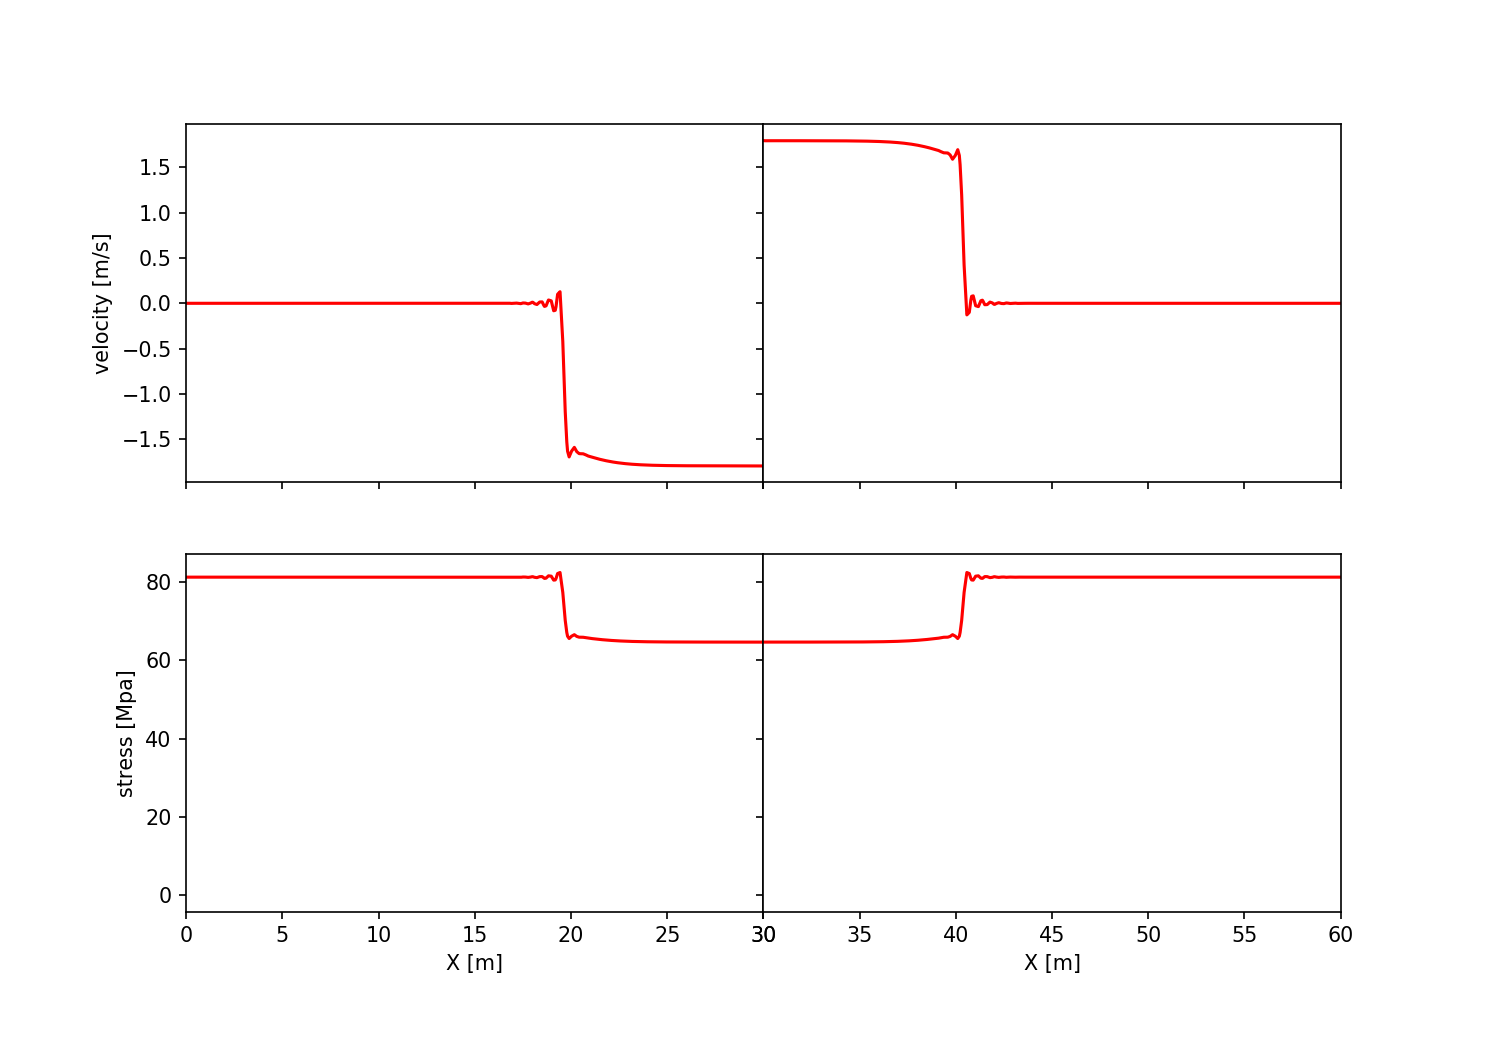

In [2]:
# Initialization and computation
# Tic
iplot  = 10  

# At the moment, keep the length of the two domain the same
# Ahysical domain x = [ax, bx] (km)
# For the first domain 
ax_1 = 0.0
bx_1 = 30.0

# Physical domain x = [ax, bx] (km)
# For the second domain
ax_2 = bx_1
bx_2 = 60.0

# Choose quadrature rules and the corresponding nodes
# We use Gauss-Legendre-Lobatto (Lobatto) or  Gauss-Legendre (Legendre) quadrature rule.

#node = 'Lobatto'
node = 'Legendre'

if node not in ('Lobatto', 'Legendre'):
    print('quadrature rule not implemented. choose node = Legendre or node = Lobatto')
    exit(-1)

# polynomial degree N: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
N = 5                        # Lagrange polynomial degree
NP = N+1                     # quadrature nodes per element

if N < 1 or N > 12:
    print('polynomial degree not implemented. choose N>= 1 and N <= 12')
    exit(-1)

# degrees of freedom to resolve the wavefield    
deg_of_freedom1 = 301        # for first domain
deg_of_freedom2 = 301        # for second domain

# estimate the number of elements needed for a given polynomial degree and degrees of freedom
num_element1 = round(deg_of_freedom1/NP)       # for first domain
num_element2 = round(deg_of_freedom2/NP)       # for second domain

# Initialize the mesh
y_1 = np.zeros(NP*num_element1)
y_2 = np.zeros(NP*num_element2)

# Generate num_element dG elements in the interval [ax, bx]
x0_1 = np.linspace(ax_1,bx_1,num_element1+1)
dx_1 = np.diff(x0_1)                           # element sizes
    
x0_2 = np.linspace(ax_2,bx_2,num_element2+1)
dx_2 = np.diff(x0_2)                           # element sizes

# Generate Gauss quadrature nodes (psi): [-1, 1] and weights (w)
if node == 'Legendre':
    GL_return = quadraturerules.GL(N)
    psi = GL_return['xi']
    w = GL_return['weights'];
    
if node == 'Lobatto':
    gll_return = quadraturerules.gll(N)
    psi = gll_return['xi']
    w = gll_return['weights']

# Use the Gauss quadrature nodes (psi) generate the mesh (y)
for i in range (1,num_element1+1):
    for j in range (1,(N+2)):
        y_1[j+(N+1)*(i-1)-1] = dx_1[i-1]/2.0 * (psi[j-1] + 1.0) +x0_1[i-1]

for i in range (1,num_element2+1):
    for j in range (1,(N+2)):
        y_2[j+(N+1)*(i-1)-1] = dx_2[i-1]/2.0 * (psi[j-1] + 1.0) +x0_2[i-1]

deg_of_freedom1 = len(y_1)                     #same for both the domains
deg_of_freedom2 = len(y_2)                     #same for both the domains

# generate the spectral difference operator (D) in the reference element: [-1, 1]  
D = specdiff.derivative_GL(N, psi, w)

# Boundary condition reflection coefficients 
r0 = 0.0                          # r=0:absorbing, r=1:free-surface, r=-1: clamped, 
rn = 0.0                          # r=0:absorbing, r=1:free-surface, r=-1: clamped, 

# Initialize the wave-fields
L_1 = 0.5*(bx_1-ax_1)
L_2 = 0.5*(bx_2-ax_2)

delta_1 = 0.01*(bx_1-ax_1)
delta_2 = 0.01*(bx_2-ax_2)

x0_1 = 0.5*(bx_1+ax_1)
x0_2 = 0.5*(bx_2+ax_2)

# Material parameters
c1s = 3.464 + 0.0*np.sin(2.0*np.pi*y_1)             # shear wave speed (km/s)
rho1 = 2.67 + 0.0*y_1                               # density (g/cm^3)
mu1 = rho1 * c1s**2                                 # shear modulus (GPa)
Z1s = rho1*c1s                                      # shear impedance

c2s = 3.464 + 0.0*y_2                               # shear wave speed (km/s)
rho2 = 2.67 + 0.0*y_2                               # density (g/cm^3)
mu2 = rho2 * c2s**2                                 # shear modulus (GPa)
Z2s = rho2*c2s                                      # shear impedance

# Choose friction law: fric_law
# We use linear (LN: T = alpha*v, alpha >=0)
# Slip-weakening (SW)
# Rate-and-state friction law (RS)

fric_law = 'RS'

if fric_law not in ('LN', 'SW', 'RS'):
    print('friction law not implemented. choose fric_law = SW or fric_law = LN')
    exit(-1)

if fric_law  in ('LN'):
    alpha = 1e1000000             # initial friction coefficient
    S = 0.0                       # initial slip (in m)
    Tau_0 = 81.24+1*0.36          # initial load (81.24 in MPa), slight increase will unlock the fault
    W = 0.0
    u_1 = np.exp(-(y_1-x0_1)**2/delta_1)                                                  # Gaussian
    u_2 = 1/np.sqrt(2.0*np.pi*delta_2**2)*np.exp(-(y_2-x0_2)**2/(2.0*delta_2**2))         # Gaussian

if fric_law  in ('SW'):
    alpha = 1e1000000              # initial friction coefficient
    S = 0.0                        # initial slip (in m)
    Tau_0 = 81.24+0.1*0.36         # initial load (81.24 in MPa), slight increase will unlock the fault
    W = 0.0
    u_1 = 0.0*np.exp(-(y_1-x0_1)**2/delta_1)                                                # Gaussian
    u_2 = 0.0/np.sqrt(2.0*np.pi*delta_2**2)*np.exp(-(y_2-x0_2)**2/(2.0*delta_2**2))         # Gaussian

if fric_law  in ('RS'):
    alpha = 1e1000000                      # initial friction coefficient                                                                                   
    S = 0.0                                # initial slip (in m)                                                                                                                             
    Tau_0 = 81.24+0.1*0.36                 # initial load (81.24 in MPa), slight increase will unlock the fault   
    W = 0.4367
    u_1 = 0.0*np.exp(-(y_1-x0_1)**2/delta_1)                                                # Gaussian
    u_2 = 0.0/np.sqrt(2.0*np.pi*delta_2**2)*np.exp(-(y_2-x0_2)**2/(2.0*delta_2**2))         # Gaussian

u_1 = np.transpose(u_1)
v_1 = np.transpose(u_1)
    
u_2 = np.transpose(u_2)
v_2 = np.transpose(u_2)

# Time stepping parameters
cfl = 0.5                            # CFL number
dt = (cfl/(max(max(c1s),max(c2s))*(2*N+1)))*min(min(dx_1), min(dx_2))         # time-step (s)
t = 0.0                              # initial time
Tend = 3.0                           # final time (s)
n = 0                                # counter

Vd = [0]
Sd = [Tau_0]
T = [t]
Slip = [0]

# Initialize animated plot   
f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(10,7))
line1 = ax1.plot(y_1, u_1,'r')
line2 = ax2.plot(y_2, u_2,'r')
line3 = ax3.plot(y_1, v_1,'r')
line4 = ax4.plot(y_2, v_2,'r')
    
ax1.set_ylabel('velocity [m/s]')
ax3.set_ylabel('stress [Mpa]')
ax3.set_xlabel('X [m]')
ax4.set_xlabel('X [m]')

ax3.set_xlim([ax_1, bx_1])
ax4.set_xlim([ax_2,bx_2])
f1.subplots_adjust(wspace=0)
plt.ion()
plt.show()

time_integrator = 'ADER'

for t in utils.drange (dt,Tend+dt,dt):
    n = n+1
    
    if time_integrator  in ('ADER'):
        ADER_Wave_1D_GL_return = timeintegrate.ADER_Wave_1D_GL(u_1,v_1,u_2,v_2,S,W,D,NP,num_element1,\
                                                            num_element2,dx_1,dx_2,w,psi,t,r0,rn,dt,\
                                                             rho1,mu1,rho2,mu2,alpha,Tau_0,fric_law)
        u_1 = ADER_Wave_1D_GL_return['Hu_1']
        v_1 = ADER_Wave_1D_GL_return['Hv_1']
        u_2 = ADER_Wave_1D_GL_return['Hu_2']
        v_2 = ADER_Wave_1D_GL_return['Hv_2']
        S   = ADER_Wave_1D_GL_return['H_d']
        W   = ADER_Wave_1D_GL_return['H_psi']
        
        
    if time_integrator  in ('RK'):
        RK4_Wave_1D_GL_return = timeintegrate.ADER_Wave_1D_GL(u_1,v_1,u_2,v_2,S,W,D,NP,num_element1,\
                                                               num_element2,dx_1,dx_2,w,psi,t,r0,rn,dt,\
                                                               rho1,mu1,rho2,mu2,alpha,Tau_0,fric_law)
        u_1 = RK4_Wave_1D_GL_return['Hu_1']
        v_1 = RK4_Wave_1D_GL_return['Hv_1']
        u_2 = RK4_Wave_1D_GL_return['Hu_2']
        v_2 = RK4_Wave_1D_GL_return['Hv_2']
        S   = RK4_Wave_1D_GL_return['H_d']
        W   = RK4_Wave_1D_GL_return['H_psi']
        
        
    
    Vd.append(np.abs(u_1[-1]-u_2[0]))
    Sd.append(v_2[0]+1.0*Tau_0)
    T.append(t)
    Slip.append(S)
      
    # Update plot                                                                                                                                                                                  
    if n % iplot == 0:
        for l in line1:
            l.remove()
            del l
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l               
        for l in line4:
            l.remove()
            del l

        # Display lines
        line1 = ax1.plot(y_1, u_1, 'r')
        line2 = ax2.plot(y_2, u_2, 'r')
        line3 = ax3.plot(y_1, Tau_0+v_1, 'r')
        line4 = ax4.plot(y_2, Tau_0+v_2, 'r')
        plt.gcf().canvas.draw()

plt.ioff()
plt.show()

<IPython.core.display.Javascript object>


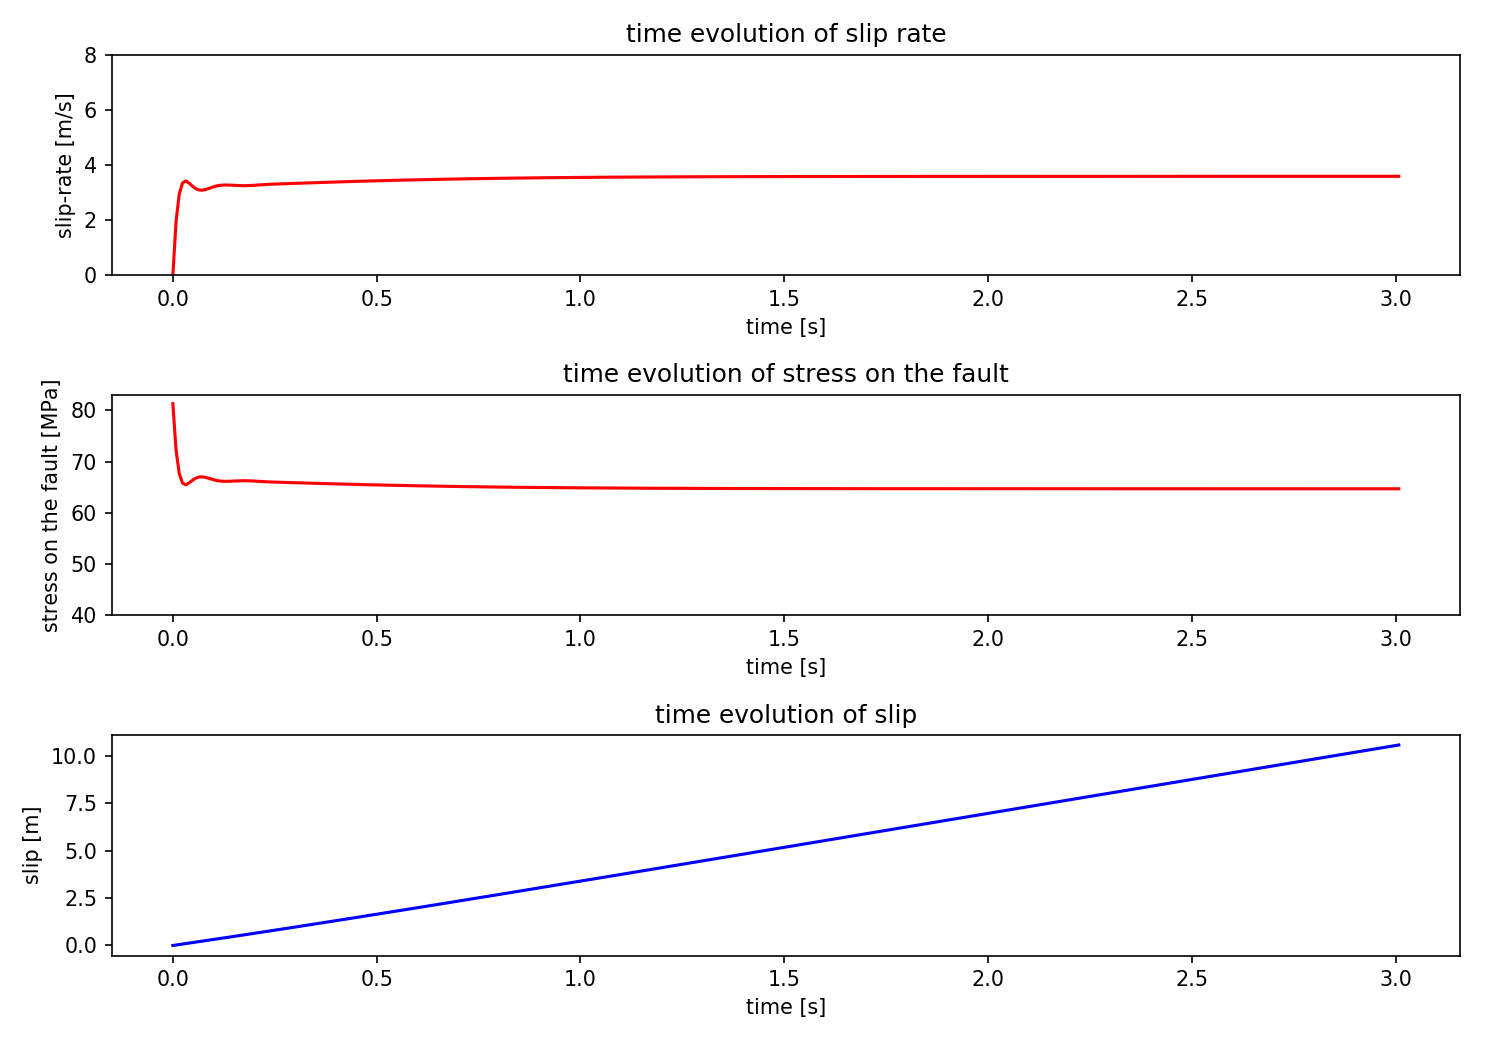

In [3]:
# Plotting time evolution of slip-rate, stress on the fault and slip
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(T,Vd,'r-')
plt.title('time evolution of slip rate')
plt.ylabel('slip-rate [m/s]')
plt.xlabel('time [s]')
plt.ylim([0, 8])

plt.subplot(3,1,2)
plt.plot(T, Sd, 'r-')
plt.title('time evolution of stress on the fault')
plt.ylabel('stress on the fault [MPa]')
plt.xlabel('time [s]')
plt.ylim([40, 83])

plt.subplot(3,1,3)
plt.plot(T, Slip, 'b-')
plt.xlabel('time [s]')
plt.ylabel('slip [m]')
plt.title('time evolution of slip')

plt.tight_layout()
plt.show()